documentation here

In [1]:
# import libraries

# image processing
from PIL import Image

# image manipulation and machine learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# file name handling
import os

# Data Handling and Analysis
import pandas as pd
import numpy as np
import json # to record training result
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import datetime # for timestamp in log

# visualization
import matplotlib.pyplot as plt
import seaborn as sns


#### Load the images and split into induvisual characters
- Inlcude scaling so the final chracter images are 28*28 pixel each

In [2]:
def extract_info_from_filename(filename):
    """Extract font number and note from the filename."""
    parts = filename.split('_')
    font_num = parts[0]
    font_note = parts[1]
    return font_num, font_note


# I have all bpm(bopomofo) characters in one bigger png, 
# and the name of these png file are fontNum_fontNote_all.png
    
# # Test the function
# filename = '14_A_all.png'
# font_num, font_note = extract_info_from_filename(filename)
# print(f"Font Number: {font_num}, Font Note: {font_note}")
# pasted test

In [3]:
def split_image_with_extracted_names(char_numbers, image_path, output_dir, grid_size=(3, 14)):
    """
    Split an image into smaller chunks and name each piece.

    Parameters
      char_numbers: A nested list(matrix) that will determine the charNum for each output image.
          I have a grid of 3 rows and 14 cols, so my matrix is also 3 rows and 14 cols.
      image_path: Path to an image file that contains all 37 bpm char for a font.
      output_dir: Where the split image will be.
      grid_size: (number_of_rows, number_of_columns) how the 37 bpm is placed in the image.
          Default grid_size is (3, 14)

    Output
      Individual characters each in one png file.
      file name formate: characterNum_fontNum_fontNote.png
      fontNote example: bold, italic, regular...
      Ex: 01_15_A.png would be for character 01 (ㄅ) from font 15.
    
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract filename info
    base_filename = os.path.basename(image_path)
    font_num, font_note = extract_info_from_filename(base_filename)
    
    # Open the image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Calculate the size of each cell
    cell_width = img_width // grid_size[1]
    cell_height = img_height // grid_size[0]

    # Ensure the number of cells matches the grid size 
    if len(char_numbers) != grid_size[0] or any(len(row) != grid_size[1] for row in char_numbers): 
        raise ValueError("Character numbers list does not match the grid size.")

    # Split the image into smaller cells
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            left = col * cell_width
            upper = row * cell_height
            right = left + cell_width
            lower = upper + cell_height
            cell_img = img.crop((left, upper, right, lower))

            # Determine the character number
            char_num = char_numbers[row][col]
            # bpm only goes from 1 to 37, skip the empty cells
            if char_num > 37:
                continue
            
            # Create the filename
            filename = f'{char_num:02d}_{font_num}_{font_note}.png'
            
            # Save the cell image
            cell_img.save(os.path.join(output_dir, filename))

In [4]:
def split_all_images(input_dir, output_dir, char_numbers, grid_size=(3, 14)):
    """
    Split all PNG images in the input directory.
    
    Parameters:
      input_dir: Directory containing the large images.
      output_dir: Directory to save the split images.
      char_numbers: A nested list (matrix) that will determine the charNum for each output image.
      grid_size: (number_of_rows, number_of_columns) for how the characters are placed in the image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(input_dir, filename)
            split_image_with_extracted_names(char_numbers, image_path, output_dir, grid_size)




In [5]:
def scale_and_pad_image(input_dir, output_dir, target_size=(28, 28)):
    """
    Scale and pad images to the target size while maintaining proportions.

    Assume each 
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            img = Image.open(os.path.join(input_dir, filename))
            img.thumbnail(target_size, Image.LANCZOS)  # Maintain aspect ratio
            width, height = img.size

            # Create a new image with white background
            new_img = Image.new('RGB', target_size, (255, 255, 255))
            paste_position = ((target_size[0] - width) // 2, (target_size[1] - height) // 2)
            new_img.paste(img, paste_position)
            new_img.save(os.path.join(output_dir, filename))


In [6]:
# Only charNum 01-37 contain charactes, 38-42 are just blank.
char_numbers = [
    list(range(1, 15)),   # Top row: 01-14
    list(range(15, 28)) + [38],  # Middle row: 15-17, 38
    list(range(28, 38)) + list(range(39, 43))  # Bottom row: 28-37, 39-42
]

# Check if the charNum matches the grid
print(char_numbers)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38], [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42]]


In [7]:
# intput and output folder for split_all_images
input_dir = 'fonts_unprocessed'
output_dir = 'font_split'

# Split the image in the input directory
split_all_images(input_dir, output_dir, char_numbers)

In [8]:
# Parameters for scaling and padding
input_dir = 'font_split'
scaled_output_dir = 'fonts_processed_scaled'
target_size = (28, 28)  # Desired size for training

# Scale and pad images
scale_and_pad_image(input_dir, scaled_output_dir, target_size)

#### Data Exploration:
- Visualize Samples
- Class Distribution
    - Skipped, because there are 15 fonts and each set of fonts has one of each character.<br>
      Read more about the font types and dataset in "note.txt"

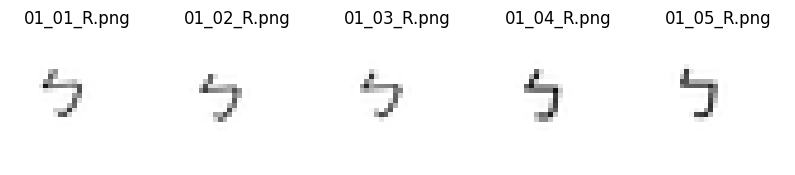

In [140]:
# Load and visualize samples
def visualize_samples(data_dir, num_samples=5):
    filenames = os.listdir(data_dir)[:num_samples]
    plt.figure(figsize=(10, 5))
    for i, filename in enumerate(filenames):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(filename)
        plt.axis('off')
    plt.show()

# Visualize some samples
data_dir = 'fonts_processed_scaled'
visualize_samples(data_dir)

#### Preprocessing:
- Normalization: Normalize the pixel values. Dividing by 255, so the scaled pixel values now range from 0 to 1, which helps the model converge faster.
- Data Augmentation: Apply data augmentation techniques such as rotation and scaling to artificially increase the size of the dataset and make the model more robust. Helps prevent overfitting.

In [10]:
# Load data, convert to gray scale,  and normalize
def load_and_preprocess_images(data_dir, target_size=(28, 28)):
    images = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert('L') # convert to grayscale
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
            img = np.expand_dims(img, axis=-1) # add channel dimension
            label = int(filename.split('_')[0]) -1  # Extract (character number -1) as label with 0 index
            images.append(img)
            labels.append(int(label))
    return np.array(images), np.array(labels)

In [11]:
# Data augmentation to improve data variation
def create_data_generator():
    datagen = ImageDataGenerator(
        rotation_range=10,        # Randomly rotate images by up to 10 degrees
        width_shift_range=0.1,    # Randomly shift images horizontally by up to 10% of total width
        height_shift_range=0.1,   # Randomly shift images vertically by up to 10% of total height
        shear_range=0.1,          # Apply random shear transformations, like make a rectangle into a parallelogram
        zoom_range=0.1,           # Apply random zoom-in and zoom-out transformations
        horizontal_flip=False,    # Characters usually aren't flipped, set to False
        fill_mode='nearest'       # How to fill newly created pixels after a transformation
    )
    return datagen


In [12]:
# Load and preprocess data
images, labels = load_and_preprocess_images(data_dir)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Verify shapes and label range
# shape is (number of samples, height, width, channels)
# each image is 28*28 pixel and grayscale, so should be (number of samples, 28, 28, 1)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("Label range in y_train:", min(y_train), "to", max(y_train))

# Create data generator
datagen = create_data_generator()

X_train shape: (504, 28, 28, 1)
X_val shape: (126, 28, 28, 1)
y_train shape: (504,)
y_val shape: (126,)
Label range in y_train: 0 to 41


#### Train and view result

In [18]:
# Function to train the model
def train_model(X_train, y_train, X_val, y_val, params):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(params['conv1_filters'], (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(params['conv2_filters'], (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(params['conv3_filters'], (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(params['dense_units'], activation='relu'),
        tf.keras.layers.Dropout(params['dropout_rate']),
        tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(datagen.flow(X_train, y_train, batch_size=params['batch_size']),
                        validation_data=(X_val, y_val),
                        epochs=params['epochs'])
    
    return model, history

In [62]:
# Function to log experiment results with incremental ID and timestamp
def log_experiment(params, history, log_file='experiment_log.json'):
    # Read existing log file to find the highest existing ID
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            log_data = json.load(file)
        if log_data:
            max_id = max(entry['session_id'] for entry in log_data)
        else:
            max_id = 0
    else:
        log_data = []
        max_id = 0
    
    new_id = max_id + 1
    timestamp = datetime.datetime.now().isoformat()

    results = []
    for epoch in range(len(history.history['accuracy'])):
        result = {
            'session_id': new_id,  # Add incremental session ID
            'params': params,
            'epoch': epoch,
            'accuracy': round(history.history['accuracy'][epoch], 3),
            'val_accuracy': round(history.history['val_accuracy'][epoch], 3),
            'loss': round(history.history['loss'][epoch], 3),
            'val_loss': round(history.history['val_loss'][epoch], 3),
            'timestamp': timestamp  # Add timestamp
        }
        results.append(result)

    log_data.extend(results)

    with open(log_file, 'w') as file:
        json.dump(log_data, file, indent=4)


In [225]:
# Function to load and transform experiment log
def load_and_transform_log(log_file='experiment_log.json', accuracy_threshold=0.8, val_accuracy_threshold=0.8, param_cols=None):
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            log_data = json.load(file)
        
        # Convert log data to DataFrame
        df = pd.DataFrame(log_data)
        
        # Ensure the columns 'max_accuracy' and 'max_val_accuracy' are created
        df['max_accuracy'] = df['accuracy'].apply(lambda x: max(x) if isinstance(x, list) else x)
        df['max_val_accuracy'] = df['val_accuracy'].apply(lambda x: max(x) if isinstance(x, list) else x)

        # Add a column to count how many times accuracy passed the threshold 
        df['accuracy_count'] = df['accuracy'].apply(lambda x: sum(i > accuracy_threshold for i in x) if isinstance(x, list) else int(x > accuracy_threshold))
        
        # Add a column to count how many times val_accuracy passed the threshold 
        df['val_accuracy_count'] = df['val_accuracy'].apply(lambda x: sum(i > val_accuracy_threshold for i in x) if isinstance(x, list) else int(x > val_accuracy_threshold))

        # Extract parameters into separate columns and combine them
        params_df = df['params'].apply(pd.Series)
        params_df['combined_params'] = params_df[param_cols].astype(str).agg('-'.join, axis=1)
        result_df = pd.concat([params_df, df.drop(columns=['params'])], axis=1)
    
        return result_df
    else:
        print(f"No log file found at {log_file}.")
        return pd.DataFrame()


In [280]:
# Function to filter DataFrame based on validation accuracy threshold and group by parameters
def filter_dataframe(df, accuracy_threshold=0.8, val_accuracy_threshold=0.8):
    # Group by session_id and relevant parameter columns and aggregate
    grouped_df = df.groupby(['session_id', 'timestamp'] + list(df.columns[:len(param_columns)])).agg({
        'max_accuracy': 'max',
        'max_val_accuracy': 'max',
        'accuracy_count': 'sum',
        'val_accuracy_count': 'sum'
    }).reset_index()
    
    # Filter by accuracy and validation accuracy thresholds 
    filtered_df = grouped_df[(grouped_df['max_accuracy'] > accuracy_threshold) & 
                             (grouped_df['max_val_accuracy'] > val_accuracy_threshold)]

    return filtered_df

    
# Function to filter the most recent session
def filter_most_recent_session(df):
    # Convert the 'timestamp' column to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Find the latest timestamp
    latest_timestamp = df['timestamp'].max()
    
    # Filter the DataFrame for the most recent session
    most_recent_session = df[df['timestamp'] == latest_timestamp]
    
    return most_recent_session

# Function to plot training and validation accuracy over epochs
def plot_accuracy(transformed_log, accuracy_col='accuracy', val_accuracy_col='val_accuracy', hue_col='combined_params', single_session=False, use_filter=False, accuracy_threshold=0.8, val_accuracy_threshold=0.8):
    plt.figure(figsize=(12, 6))
    
    if single_session:
        # Filter for the most recent session 
        transformed_log = filter_most_recent_session(transformed_log)
        
        # Plot for a single training session
        sns.lineplot(data=transformed_log, x='epoch', y=accuracy_col, label='Training Accuracy')
        sns.lineplot(data=transformed_log, x='epoch', y=val_accuracy_col, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy in a training session')
    else:
        if use_filter:
            # Filter DataFrame based on accuracy and validation accuracy thresholds
            filtered_df = filter_dataframe(transformed_log, accuracy_threshold, val_accuracy_threshold)

            # Extract session_id from filtered_df
            session_ids = filtered_df['session_id']
            
            # match ID and filter with original dataframe
            transformed_log = transformed_log[transformed_log['session_id'].isin(session_ids)]
        
        # Ensure the hue column exists in the DataFrame
        # if hue_col in transformed_log.columns:
        if 'session_id' in transformed_log.columns:
        
            # Plot for comparisons across different parameter sets
            # sns.lineplot(data=transformed_log, x='epoch', y=accuracy_col, hue=hue_col)
            sns.lineplot(data=transformed_log, x='epoch', y=val_accuracy_col, hue='session_id')
            plt.title('Validation Accuracy Over Epochs | Threshold {val_accuracy_threshold}')
            
        else:
            print(f"Column '{hue_col}' does not exist in the DataFrame.")

    # plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage
# For a single training session
# plot_accuracy(transformed_log, single_session=True)

# For comparisons across different parameter sets
# plot_accuracy(transformed_log)

In [287]:
# Try out different hyperparameters
params = {
    'conv1_filters': 64,
    'conv2_filters': 64,
    'conv3_filters': 128,
    'dense_units': 128,
    'dropout_rate': 0.2,
    'learning_rate': 0.001, # 0.001, 0.0001
    'batch_size': 32,
    'epochs': 200 # 10, 50, 100
}

# Train the model and log results
model, history = train_model(X_train, y_train, X_val, y_val, params)
log_experiment(params, history)

Epoch 1/200


C:\Users\s9602\Github\Bopomofo-Model\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0145 - loss: 3.7456 - val_accuracy: 0.0159 - val_loss: 3.7457
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0201 - loss: 3.7364 - val_accuracy: 0.0159 - val_loss: 3.7440
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0213 - loss: 3.7362 - val_accuracy: 0.0159 - val_loss: 3.7543
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0316 - loss: 3.7360 - val_accuracy: 0.0159 - val_loss: 3.7590
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0318 - loss: 3.7360 - val_accuracy: 0.0159 - val_loss: 3.7680
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0344 - loss: 3.7312 - val_accuracy: 0.0159 - val_loss: 3.7708
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.0355 - loss: 3.7354 - val_accuracy: 0.0000e+00 - val_loss: 3.7687
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0189 - loss: 3.7266 - val_accuracy: 0.0000e+00

Transformed Log:
   conv1_filters  conv2_filters  conv3_filters  dense_units  dropout_rate  \
0           32.0           64.0          128.0        128.0           0.5   
1           32.0           64.0          128.0        128.0           0.5   
2           32.0           64.0          128.0        128.0           0.5   
3           32.0           64.0          128.0        128.0           0.5   
4           32.0           64.0          128.0        128.0           0.5   

   learning_rate  batch_size  epochs  \
0          0.001        32.0    10.0   
1          0.001        32.0    10.0   
2          0.001        32.0    10.0   
3          0.001        32.0    10.0   
4          0.001        32.0    10.0   

                             combined_params  session_id  epoch  accuracy  \
0  32.0-64.0-128.0-128.0-0.5-0.001-32.0-10.0           1      0     0.018   
1  32.0-64.0-128.0-128.0-0.5-0.001-32.0-10.0           1      1     0.020   
2  32.0-64.0-128.0-128.0-0.5-0.001-32.0-10.0    

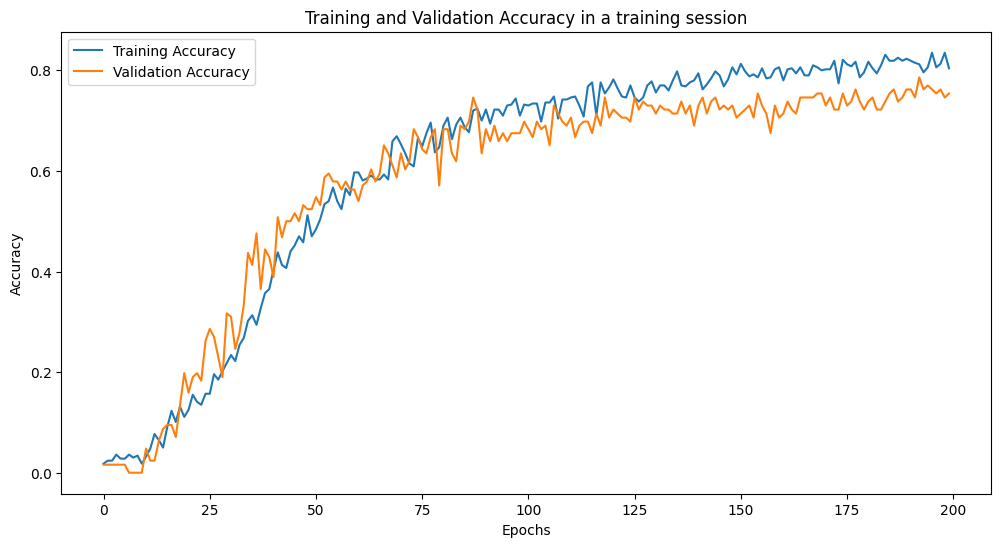

In [288]:
# Load and transform the experiment log
param_columns = ['conv1_filters', 'conv2_filters', 'conv3_filters', 'dense_units', 'dropout_rate', 'learning_rate', 'batch_size', 'epochs']
transformed_log = load_and_transform_log(param_cols=param_columns)
print("Transformed Log:")
print(transformed_log.head())

# Filter and display results with val_accuracy > 0.8
filtered_log = filter_dataframe(transformed_log)
print("Filtered Results (val_accuracy > 0.8):")
print(filtered_log)

# ######################## Use custom threshhold

# # Load and transform the experiment log with custom thresholds
# transformed_log = load_and_transform_log(accuracy_threshold=0.85, val_accuracy_threshold=0.83)
# print("Transformed Log:")
# print(transformed_log.head())

# # Filter and display results with val_accuracy > threshold
# filtered_log = filter_dataframe(transformed_log, accuracy_threshold=0.85, val_accuracy_threshold=0.83)
# print("Filtered Results (val_accuracy > 0.85):")
# print(filtered_log)

###########################
# Plot for a single training session
plot_accuracy(transformed_log, single_session=True)

# Plot for multiple training sessions(only show val_accuracy)
# plot_accuracy(transformed_log, use_filter=True)


In [233]:
# print("Columns in transformed_log:", transformed_log.columns)
# print("Sample data from transformed_log:\n", transformed_log.head())

### Test with test dataset

16_T is my new handwritten set. I filled out the characters out of order.

In [152]:
# Only charNum 01-37 contain characters, 38-42 are just blank.
char_numbers = [
    [12,33,22,7,14,31,20,1,10,16,3,8,17,28],
    [34,11,13,21,6,4,15,27,2,26,25,18,29,9],
    [35,23,24,32,36,38,5,37,39,19,30,40,41,42]
]

# Check if the charNum matches the grid
print(char_numbers)

[[12, 33, 22, 7, 14, 31, 20, 1, 10, 16, 3, 8, 17, 28], [34, 11, 13, 21, 6, 4, 15, 27, 2, 26, 25, 18, 29, 9], [35, 23, 24, 32, 36, 38, 5, 37, 39, 19, 30, 40, 41, 42]]


In [306]:
# intput and output folder for split_all_images
input_dir = 'test_unprocessed'
output_dir = 'test_split'

# Split the image in the input directory
split_all_images(input_dir, output_dir, char_numbers)

In [307]:
# Parameters for scaling and padding
input_dir = 'test_split'
scaled_output_dir = 'test_processed_scaled'
target_size = (28, 28)  # Desired size for training

# Scale and pad images
scale_and_pad_image(input_dir, scaled_output_dir, target_size)

#### Data Exploration:
- Visualize Samples

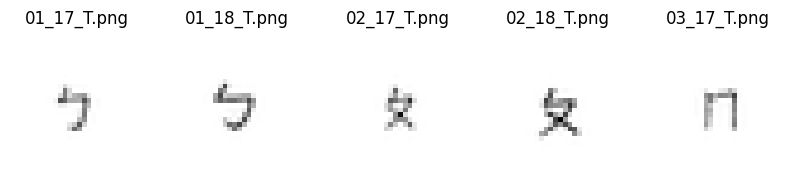

In [308]:
# Load and visualize samples
def visualize_samples(data_dir, num_samples=5):
    filenames = os.listdir(data_dir)[:num_samples]
    plt.figure(figsize=(10, 5))
    for i, filename in enumerate(filenames):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(filename)
        plt.axis('off')
    plt.show()

# Visualize some samples
data_dir = 'test_processed_scaled'
visualize_samples(data_dir)

In [309]:
# Load and preprocess test data
test_images, test_labels = load_and_preprocess_images(data_dir)

# Verify shapes and label range
print("test image shape:", test_images.shape)
print("Label range in test:", min(test_labels), "to", max(test_labels))

test image shape: (74, 28, 28, 1)
Label range in test: 0 to 36


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Classes: [[9.9640995e-01 4.5646054e-08 7.7544615e-07 ... 3.4486557e-15
  3.7316180e-15 4.0253089e-15]
 [9.9415261e-01 4.8944312e-06 3.4791694e-09 ... 5.2471287e-19
  2.3977892e-18 4.2652185e-19]
 [3.0458943e-06 3.5897785e-01 2.2969484e-06 ... 4.3297370e-16
  8.0449883e-13 8.1428824e-16]
 ...
 [6.4311971e-06 7.9191327e-03 1.1286865e-07 ... 5.9919856e-14
  7.7364261e-12 1.6536323e-13]
 [3.2440003e-06 8.2053141e-08 3.4300289e-03 ... 1.8018681e-10
  5.9381483e-07 1.5775641e-10]
 [7.3030824e-05 4.3186148e-08 1.5098913e-01 ... 7.0752776e-07
  1.4874067e-04 6.3717016e-07]]
Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.00      0.00         2
           5    

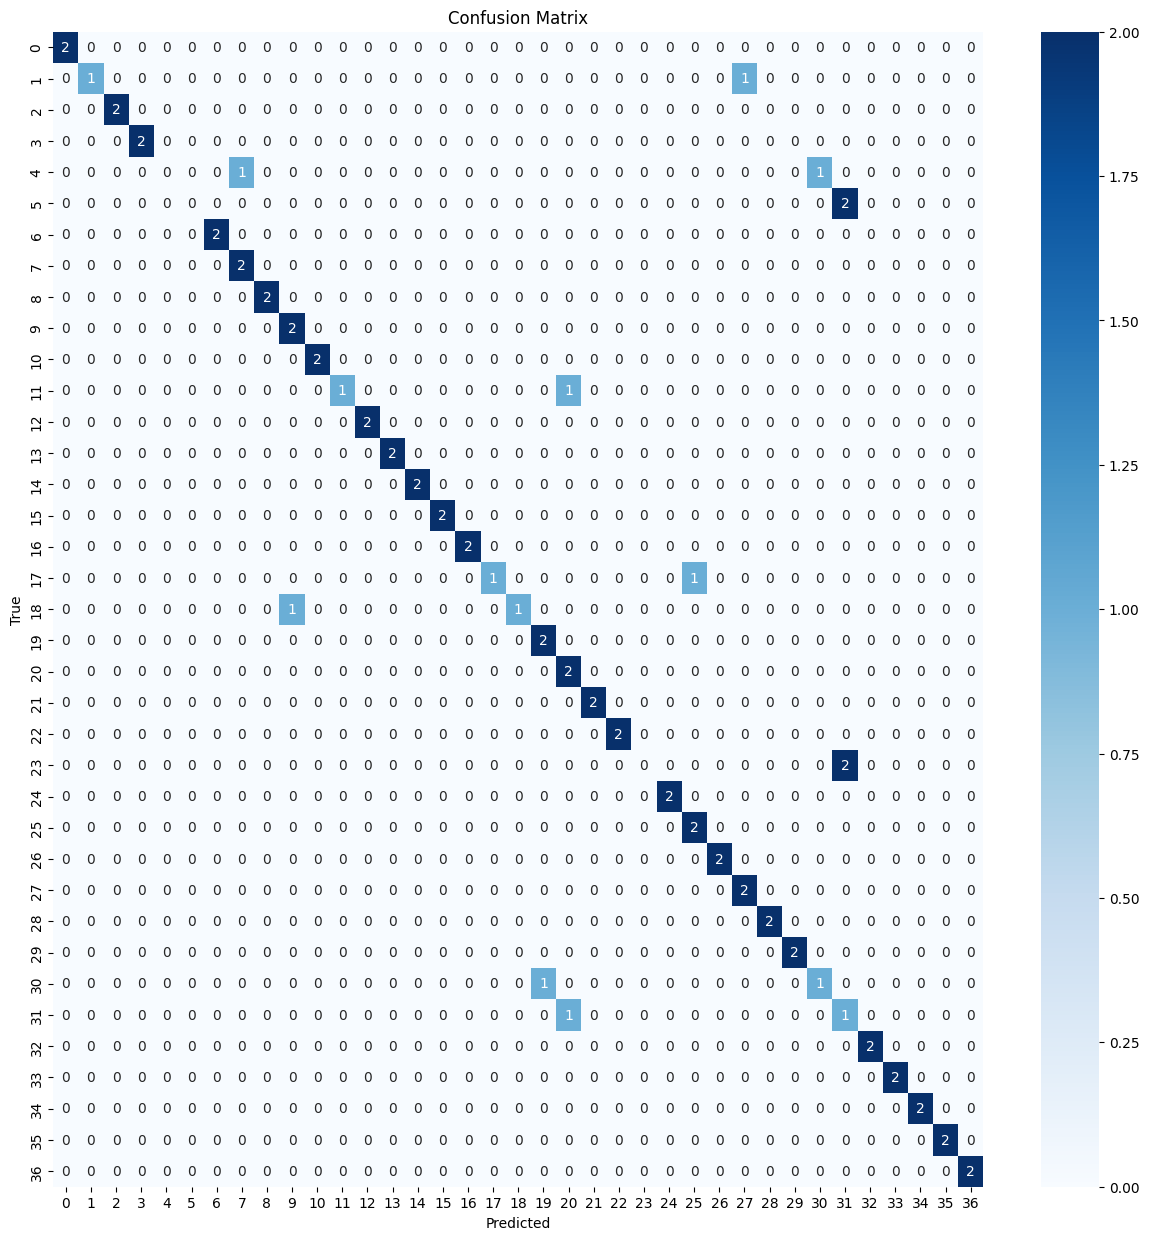

In [310]:
# Make predictions on the test data
predictions = model.predict(test_images)

# Print the predicted classes
print("Predicted Classes:", predictions)

# For classification, get the class with the highest probability 
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model by comparing predictions with true labels
accuracy = accuracy_score(test_labels, predicted_classes)
report = classification_report(test_labels, predicted_classes, zero_division=1)

# Print the evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Assuming you have the true labels (test_labels) and predicted labels (predicted_classes)
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(37), yticklabels=range(37))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
